In [15]:
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def tokenize(text):

  pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')

  return pattern.findall(text.lower())

In [4]:
# build dictionary
def mapping(text_array):

  idx_to_word = {}
  word_to_idx = {}

  i=0; j=0
  for idx, word in enumerate(text_array):
    if word not in idx_to_word.values():
      idx_to_word[i] = word
      i+=1
      
    
    if word not in word_to_idx.keys():
      word_to_idx[word] = j
      j+=1
      

  return idx_to_word, word_to_idx

In [5]:
def one_hot_encoding(text_array, word_to_idx, window_size):

  matrix = []

  for idx, word in enumerate(text_array):
    
    center_vec = [0 for w in word_to_idx]
    center_vec[word_to_idx[word]] = 1


    context_vec = []
    for i in range(-window_size, window_size+1):
      
      if i == 0 or idx+i < 0 or idx+i >= len(text_array) or word == text_array[idx+i]:
        continue
      
      temp = [0 for w in word_to_idx]
      temp[word_to_idx[text_array[idx+i]]] = 1 

      context_vec.append(temp)
      
    matrix.append([center_vec, context_vec])
    

  return matrix

In [6]:
def softmax(u):
  return [np.exp(u_j) / np.sum(np.exp(u)) for u_j in u]

In [7]:
def forward_pass(wt, w1, w2):

  wt = np.array(wt)

  h = np.dot(wt.T, w1)

  u = np.dot(h, w2)
  
  return softmax(u), h, u

In [8]:
def loss(w_c, u):
  return -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))

In [9]:
def error(out, w_c):
  out = np.array(out) 
  w_c = np.array(w_c)

  return np.sum([np.subtract(out, w) for w in w_c], axis=0)

In [10]:
def backprop(out, word, w1, w2, h):
  err = error(out, word[1]).T

  dw2 = np.outer(err, h)
  EH = np.dot(err, w2.T)
  dw1 = np.outer(EH, np.array(word[0]).T)

  return dw1.T, dw2.T

In [11]:
def learning(w1, w2, dw1, dw2, lr):
  w1 = np.subtract(w1, np.multiply(lr, dw1))
  w2 = np.subtract(w2, np.multiply(lr, dw2))

  return w1, w2

In [27]:
def train(words, vocab, lr, epochs, dim):

  w1 = np.random.uniform(-1, 1, (len(vocab), dim)) * 0.01
  w2 = np.random.uniform(-1, 1, (dim, len(vocab))) * 0.01

  history = {}
  for e in range(epochs):

    l = 0 # total loss

    for word in words:
      out, h, u = forward_pass(word[0], w1, w2)
      dw1, dw2 = backprop(out, word, w1, w2, h)
      w1, w2 = learning(w1, w2, dw1, dw2, lr)

      l += loss(word[1], u)
    
    if e % 100 == 0:
      history[e] = l
      print(f"{e}: loss: {l}")
  
  return w1, w2, history

In [28]:
def predict(word, w1, w2, matrix, words, indices):
  word = word.lower()
  out, _, _ = forward_pass(matrix[words[word]][0], w1, w2)

  most_likely_idxs = np.array(out).argsort()[-4:][::-1]
  return [indices[w] for w in most_likely_idxs]

In [29]:
text = "Examination is a crucial way to assess students' academic performance, either through the objective or subjective pattern. The objective multiple choice questions can be easily evaluated by the pre-defined correct answers. However, the subjective questions allow student to write the descriptive answers from which the evalutor can know how much knowledge the students have gained and assign marks based on their judgement. In general, subjective answers are much longer than the objective questions and carry much more context. So that evaluting subjective answers manually is very tedious and time-consuming for evaluators. In addition, the marks assigned to the same subjective questions can be varied from evaluator to evaluator, depending on their ways of evaluating, moods at the evaluating moment, and even their personal relationship with students. Therefore automated evaluation for subjective answers with the consistent process becomes necessary, not only the human efforts applied in this repetitive task can be saved and spent on other more meaningful education endeavors, but the evaluation results will be fair and plausible for students. For universities and colleges, due to the recent Covid-19 pandemic, most of them shift the examinations to the online mode. Therefore, developing a subjective answer evaluation model dovetails with the actual needs of the school and has huge application value."

tokens = tokenize(text)
idxs, words = mapping(tokens)
mat = one_hot_encoding(tokens, words, window_size=2)

w1, w2, history = train(mat, words, lr=0.01, epochs=1000, dim=5)

0: loss: 4104.390833663494
100: loss: 3469.0620749490417
200: loss: 2740.3726916360097
300: loss: 2539.25491555108
400: loss: 2452.534306738725
500: loss: 2401.400822439564
600: loss: 2368.6848310041455
700: loss: 2344.9070760687705
800: loss: 2326.5484476909282
900: loss: 2311.3199013888698


Text(0, 0.5, 'Loss')

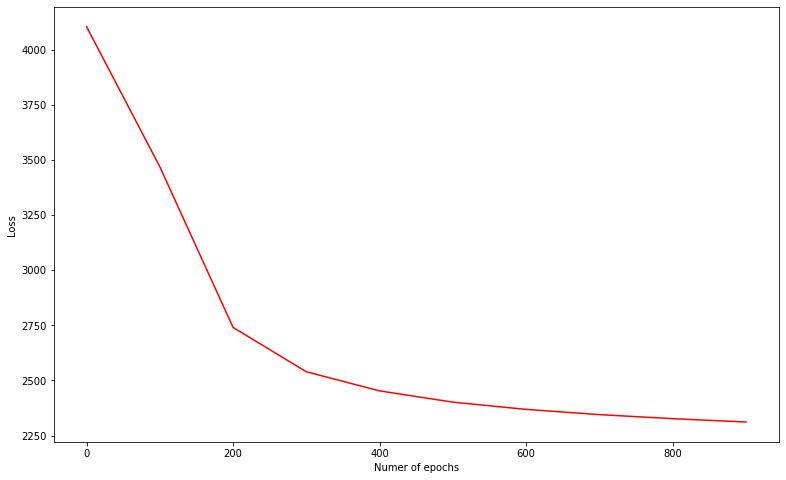

In [30]:
plt.figure(figsize=(13, 8))
plt.plot(list(history.keys()), list(history.values()), color='red')
plt.xlabel('Numer of epochs')
plt.ylabel('Loss')

In [32]:
predict('subjective', w1, w2, mat, words, idxs)

['subjective', 'answers', 'the', 'is']